In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import string
import random
import time

# Actividad Evaluada 2: Filtros de Bloom

## Simulación de Filtros de Bloom

Escribe un programa que pueda simular la probabilidad de falsos positivos que ocurren en un Filtro de Bloom cuando le entregamos un string que no es parte de su set de llaves. Espećıficamente, tu 
programa debe recibir como parámetros:

- El tamaño n del vector de bits B del Filtro de Bloom.

- La cantidad k de hashes a usar.

- La cardinalidad m del conjunto M de valores conocidos.

- La cantidad s de simulaciones a hacer.

Tu simulación debe incializar un filtro de bloom, y luego probar con s strings aleatorios que no estén en M , revisando si esos string son marcados como falsos positivos por el algoritmo, a fin de estimar la probabilidad. Puedes usar la librer̀ıa hashlib de python para programar tus tablas de hash.

Ahora, ejecuta tu simulación una cantidad s = 1000 veces para combinaciones de parámetros m = 1000. 
n = [m, 2m, 3m, 4m, 5m, 6m, 7m, 8m] y k = [1, 2, 3, 4, 5].

¿Qué valores encontraste que disminuyan la probabilidad de falsos positivos?



In [2]:
class BloomFilters:
    def __init__(self, m, k):
        self.m = m 
        self.bit_vector = self.make_vector(m)
        self.hash_functions = self.make_functions(k)

    def hash_function(self, input_string, salt):
        combined_input = f"{input_string}-{salt}"
        hash_value = int(hashlib.sha256(combined_input.encode()).hexdigest(), 16)
        return hash_value % self.m

    def make_functions(self, k):
        functions = []
        for num in range(k):
            functions.append(lambda x, salt=num: self.hash_function(x, salt))
        return functions

    def make_vector(self, m):
        return [False] * m

    def add(self, text):
        for function in self.hash_functions:
            index = function(text)
            self.bit_vector[index] = True

    def search(self, text):
        for function in self.hash_functions: 
            index = function(text)
            if not self.bit_vector[index]:
                return False
        return True

In [3]:
def random_string_list(lenght):
    string_list = []
    for i in range(lenght):
        output_string = ''.join(random.SystemRandom().choice(string.ascii_letters + string.digits) for _ in range(random.randint(0,15)))
        string_list.append(output_string)
    return string_list

def percentage_false_positives(results):
    return int((results.count(False)/len(results))*100)

In [4]:
# Valores que se pueden cambiar 
m = 1000
s = 25

# Pruebas de Bloom que vamos a hacer
bits = [m*(x + 1) for x in range(5)]
num_func_hash = [x + 1 for x in range(5)]

In [5]:
# Por la cantidad de tests se demora aprox 30 seg en correr.
trials = {}

for trial in range(0, s):
    percentages = {}
    for bit in bits:
        for num in num_func_hash:
            results = []

            bloom_filter = BloomFilters(bit, num)

            in_filter = random_string_list(m)
            out_filter = random_string_list(m)

            for value in in_filter:
                bloom_filter.add(value)
            for non_value in out_filter:
                results.append(bloom_filter.search(non_value))
            percentages[(bit, num)] = percentage_false_positives(results)
    trials[trial] = percentages

In [6]:
mean_results = {}
cumulative_sums = {}
counts = {}

for trial, percentages in trials.items():
    for key, value in percentages.items():
        if key not in cumulative_sums:
            cumulative_sums[key] = 0
            counts[key] = 0
        
        cumulative_sums[key] += value
        counts[key] += 1

for key in cumulative_sums:
    mean_results[key] = int(cumulative_sums[key] / counts[key])
print(mean_results)

{(1000, 1): 35, (1000, 2): 25, (1000, 3): 15, (1000, 4): 8, (1000, 5): 3, (2000, 1): 55, (2000, 2): 56, (2000, 3): 51, (2000, 4): 44, (2000, 5): 37, (3000, 1): 65, (3000, 2): 70, (3000, 3): 69, (3000, 4): 67, (3000, 5): 63, (4000, 1): 71, (4000, 2): 77, (4000, 3): 78, (4000, 4): 77, (4000, 5): 75, (5000, 1): 74, (5000, 2): 80, (5000, 3): 82, (5000, 4): 82, (5000, 5): 82}


In [7]:
color_palette =  ["#0079FF", "#00DFA2", "#F6FA70", "#FF0060", "#4635B1"]

x_values = sorted(set(key[0] for key in mean_results.keys()))
y_values = sorted(set(key[1] for key in mean_results.keys()))
results = np.array([[mean_results.get((x, y), 0) for y in y_values] for x in x_values])


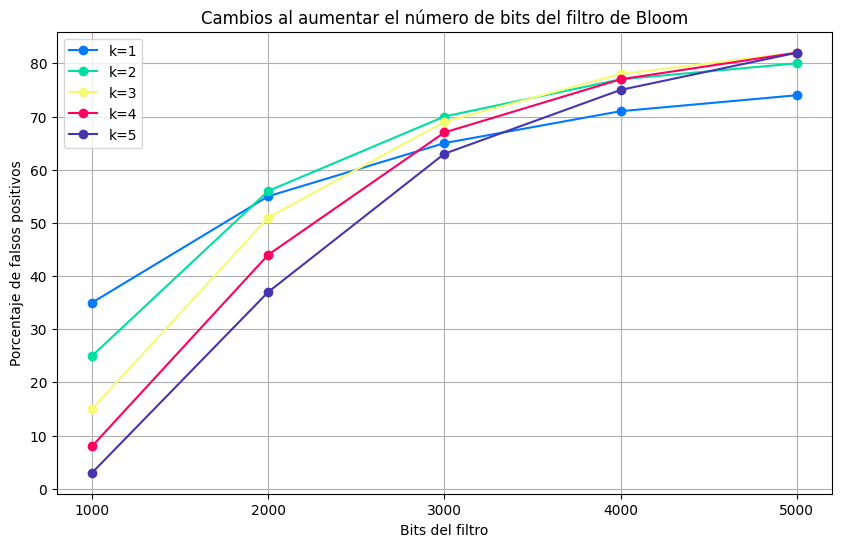

In [8]:
plt.figure(figsize=(10, 6))

for idx, y in enumerate(y_values):
    plt.plot(x_values, results[:, y-1], marker='o', label=f'k={y}', color=color_palette[idx])

plt.title('Cambios al aumentar el número de bits del filtro de Bloom')
plt.xlabel('Bits del filtro')
plt.ylabel('Porcentaje de falsos positivos')
plt.xticks(x_values)
plt.legend()
plt.grid()
plt.show()

### **Analisis**
Vemos que independiente del numero de funciones de Hash, al aumentar los bits, aumenta el porcentaje de falsos positivos. 

Para este caso, el que menos cambios muestra es cuando tenemos ``k = 1`` funciones de hash porque el crecimiento no es tan exponencial al aumentar los bits. En caso de no saber cuantos bits tenemos, es mejor deribar a tener solo una función de hash. 

En general los tienen el menor porcentaje de falsos positivos son los que tienen 1000 bits. 
En este caso, teniendo el promedio de 25 tests, lo mejor fue tener ``m = 1000`` bits y ``k = 5`` funciones de hash. 


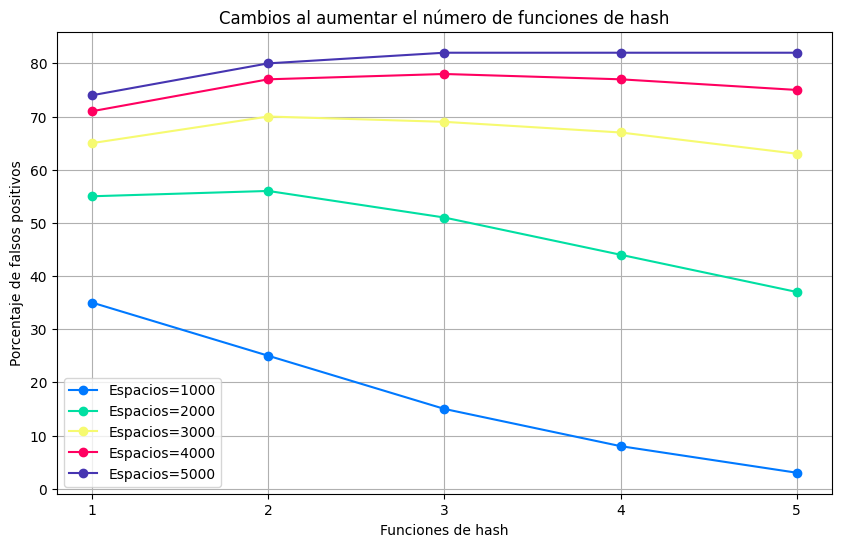

In [9]:
plt.figure(figsize=(10, 6))
for idx, x in enumerate(x_values):
    plt.plot(y_values, results[x_values.index(x)], marker='o', label=f'Espacios={x}', color=color_palette[idx])
plt.title('Cambios al aumentar el número de funciones de hash')
plt.xlabel('Funciones de hash')
plt.ylabel('Porcentaje de falsos positivos')
plt.xticks(y_values)
plt.legend()
plt.grid()
plt.show()

### **Analisis**
Vemos que independiente del numero de bits en el arreglo, al aumentar las funciones de hash, disminuye el porcentaje de falsos positivos. 

Para este caso, se presenta una baja grande para los bits ``m = 1000`` al aumentar el número de funciones de hash. En caso de no saber cuantas funciones tenemos, es mejor deribar a tener 1000 bits. 

En general los tienen el menor porcentaje de falsos positivos son los que tienen 5 funciones de hash. 

En este caso, teniendo el promedio de 25 tests, lo mejor fue tener ``m = 1000`` bits y ``k = 5`` funciones de hash. 

## Filtros de Bloom temporales

Actualiza el código de tu simulación para que pueda simular este nuevo esquema. Ahora tu simulación recibe un parámetro adicional t, y va a funcionar de la siguiente forma: Al comienzo, debes correr tu simulación por t tiempos, simulando en cada instante que viste un 20% de los valores de M ′ y actualizando el filtro de Bloom para que tome en cuenta que los valores que
no se han visto en cuatro intervalos de tiempo seguidos ya no forman parte de M ′, de acuerdo a tu
esquema (la respuesta a la parte 2.1). Luego de eso, recibes s strings aleatorios, a fin de simular la probabilidad de un falso positivo, como antes.


In [10]:
class BloomFiltersTemp:
    def __init__(self, m, k, p):
        self.m = m 
        self.k = k
        self.period = p
        self.bit_vector = self.make_vector(m)
        self.last_seen = self.make_vector(m)
        self.hash_functions = self.make_functions(k)

    def hash_function(self, input_string, salt):
        combined_input = f"{input_string}-{salt}"
        hash_value = int(hashlib.sha256(combined_input.encode()).hexdigest(), 16)
        return hash_value % self.m

    def make_functions(self, k):
        functions = []
        for num in range(k):
            functions.append(lambda x, salt=num: self.hash_function(x, salt))
        return functions

    def make_vector(self, m):
        return [0] * m

    def add(self, text):
        current_time = time.time()
        for salt in range(self.k):
            index = self.hash_function(text, salt)
            if self.bit_vector[index] < 3:
                self.bit_vector[index] += 1
            self.last_seen[index] = current_time

    def search(self, text):
        states = []
        for salt in range(self.k):
            index = self.hash_function(text, salt)
            states.append(self.bit_vector[index])
    
        if any(state == 0 for state in states):
            return 0
        elif any(state == 1 for state in states):
            return 0.5
        else:
            return 1

    def cleanup(self):
        current_time = time.time()
        for i in range(self.m):
            if current_time - self.last_seen[i] > self.period and self.bit_vector[i] > 0:
                self.bit_vector[i] -= 1


Simula de nuevo para t = 100 y m′ = 4m, y las mismas conbinaciones de n y k que antes (recuerda
que tu espacio permitido ahora es 2n, o dos bits por cada entrada entre 0 y n−1). Compara la mejor
probabilidad de falso positivo en este caso con tu respuesta de la parte 1.


In [11]:
# Valores que se pueden cambiar 
m = 1000
s = 25
t = 100

# Pruebas de Bloom que vamos a hacer
bits = [m*(x + 1) for x in range(5)]
num_func_hash = [x + 1 for x in range(5)]

In [12]:
# Por la cantidad de tests se demora aprox 30 seg en correr.
trials_temp = {}
for trial in range(0, s):
    percentages_temp = {}
    for bit in bits:
        for num in num_func_hash:
            results = []

            bloom_filter = BloomFiltersTemp(bit, num, t)

            in_filter = random_string_list(m)
            out_filter = random_string_list(m)

            for value in in_filter:
                bloom_filter.add(value)

            bloom_filter.cleanup()

            for non_value in out_filter:
                results.append(bloom_filter.search(non_value))
            percentages_temp[(bit, num)] = percentage_false_positives(results)
    trials_temp[trial] = percentages

In [13]:
mean_results_temp = {}
cumulative_sums_temp = {}
counts_temp = {}

for trial, percentages in trials_temp.items():
    for key, value in percentages_temp.items():
        if key not in cumulative_sums_temp:
            cumulative_sums_temp[key] = 0
            counts_temp[key] = 0
        
        cumulative_sums_temp[key] += value
        counts_temp[key] += 1

for key in cumulative_sums:
    mean_results_temp[key] = int(cumulative_sums_temp[key] / counts_temp[key])
print(mean_results_temp)

{(1000, 1): 36, (1000, 2): 31, (1000, 3): 13, (1000, 4): 8, (1000, 5): 3, (2000, 1): 60, (2000, 2): 56, (2000, 3): 53, (2000, 4): 45, (2000, 5): 33, (3000, 1): 63, (3000, 2): 70, (3000, 3): 71, (3000, 4): 68, (3000, 5): 65, (4000, 1): 71, (4000, 2): 75, (4000, 3): 79, (4000, 4): 76, (4000, 5): 77, (5000, 1): 73, (5000, 2): 83, (5000, 3): 84, (5000, 4): 83, (5000, 5): 79}


In [14]:
x_values_temp = sorted(set(key[0] for key in mean_results_temp.keys()))
y_values_temp = sorted(set(key[1] for key in mean_results_temp.keys()))
results_temp = np.array([[mean_results_temp.get((x, y), 0) for y in y_values_temp] for x in x_values_temp])

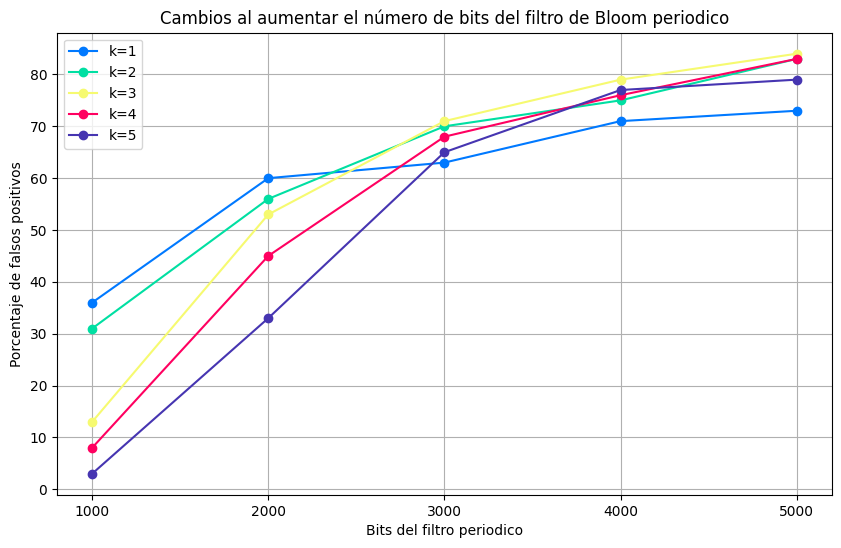

In [15]:
plt.figure(figsize=(10, 6))

for idx, y in enumerate(y_values_temp):
    plt.plot(x_values_temp, results_temp[:, y-1], marker='o', label=f'k={y}', color=color_palette[idx])


plt.title('Cambios al aumentar el número de bits del filtro de Bloom periodico')
plt.xlabel('Bits del filtro periodico')
plt.ylabel('Porcentaje de falsos positivos')
plt.xticks(x_values)
plt.legend()
plt.grid()
plt.show()

### **Analisis**
Vemos que independiente del numero de funciones de Hash, al aumentar los bits, aumenta el porcentaje de falsos positivos. Pero a diferencia de la otra estrategia, el crecimiento no es tan directo que el anterior. Cuando tenemos una función de hash, no crece tanto entre los 1000 de bins.

Para los ``k = 2`` y ``k = 4`` también baja el porcentaje máximo al que llega. 

mantengo para este caso, el que menos cambios muestra es cuando tenemos ``k = 1`` funciones de hash porque el crecimiento no es tan exponencial al aumentar los bits. En caso de no saber cuantos bits tenemos, es mejor deribar a tener solo una función de hash. 

En general los tienen el menor porcentaje de falsos positivos son los que tienen 1000 bits. 
En este caso, teniendo el promedio de 25 tests, lo mejor fue tener ``m = 1000`` bits y ``k = 5`` funciones de hash. 

La conclusión a la que llegamos es igual, pero podemos ver que las diferencias entre bits no es tan agresiva. 

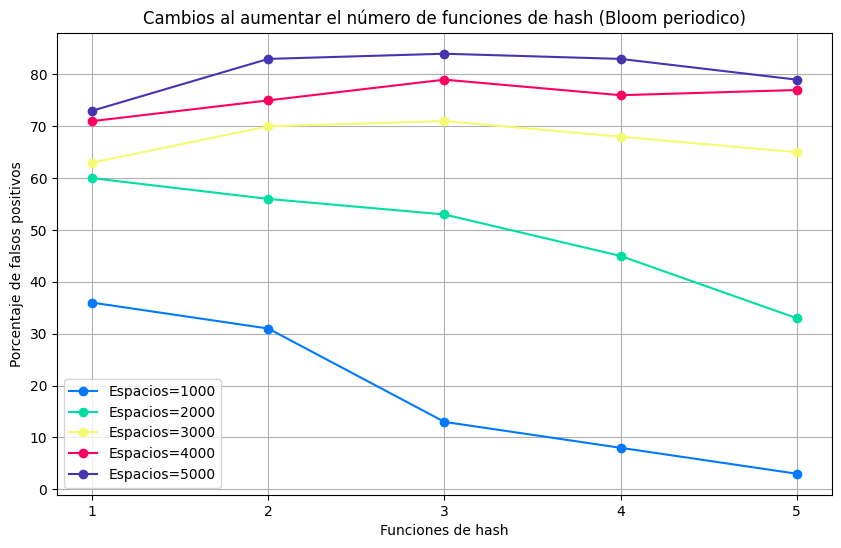

In [16]:
plt.figure(figsize=(10, 6))
for idx, x in enumerate(x_values_temp):
    plt.plot(y_values_temp, results_temp[x_values_temp.index(x)], marker='o', label=f'Espacios={x}', color=color_palette[idx])
plt.title('Cambios al aumentar el número de funciones de hash (Bloom periodico)')
plt.xlabel('Funciones de hash')
plt.ylabel('Porcentaje de falsos positivos')
plt.xticks(y_values)
plt.legend()
plt.grid()
plt.show()

### **Analisis**
Vemos que ahora el numero de bits, afectará cuanto aumenta el porcentaje de falsos positivos. Si hay entre 4000 y 5000 bits, el porcentaje aumentará entre k = 1 a k = 3. Es mejor elegir una cantidad de bits bajas porque así disminuyen los errores. 

Para este caso, se presenta la baja para los bits ``m = 1000`` no es tan brusca como sin ocupar la limpieza. A pesar de esto, sigue siendo la mejor elección. En caso de no saber cuantas funciones tenemos, es mejor deribar a tener 1000 bits. 

En general los tienen el menor porcentaje de falsos positivos son los que tienen 5 funciones de hash. Esto no se cumple para los bits 4000 y 5000, que es mayor a cuando tenemos una función. 

Así que no podemos hacer muchas generalizaciones de esta parte, podríamos decidir de ocupar menos funciones si hay muchos bits, o ocupar muchas funciones si hay pocos bits. 


En este caso se repite, teniendo el promedio de 25 tests, lo mejor fue tener ``m = 1000`` bits y ``k = 5`` funciones de hash. 

Aunque muestra una falta de generalización, hay que trabajar con más cuidado que antes. 